In [84]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import gurobipy as grb
import os
import time

# EX 3

## 1.Load data

In [85]:
f = scipy.io.loadmat('flow.mat')["flow"].reshape(28,)
C = scipy.io.loadmat('capacities.mat')["capacities"].reshape(28,)
B = scipy.io.loadmat('traffic.mat')["traffic"]
l = scipy.io.loadmat('traveltime.mat')["traveltime"].reshape(28,)

## 2. Define graph

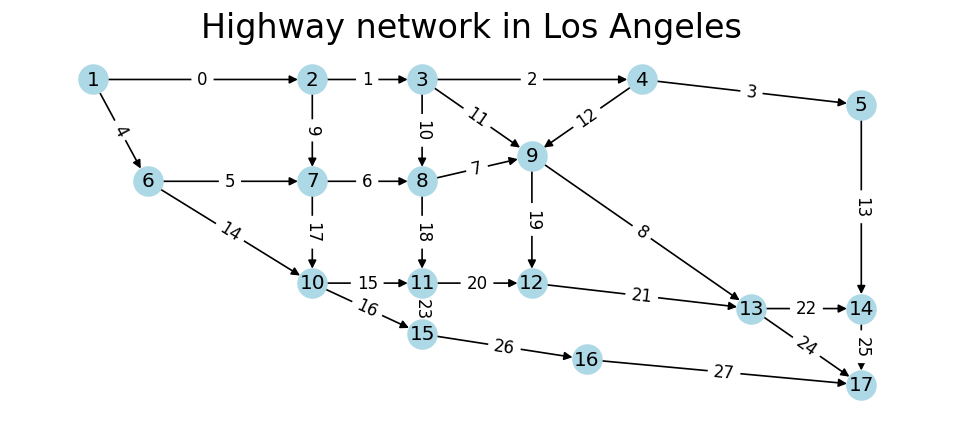

In [86]:
fig, ax = plt.subplots(figsize = (10,4), dpi=120)


n_edges = B.shape[1]
n_nodes = B.shape[0]

G = nx.DiGraph()
G.add_nodes_from(range(1,n_nodes+1))
edge_labels={}

for j in range(n_edges):
  for i in range(0,n_nodes):
    if(B[i][j] == 1):
      start = i + 1 # node i is the start of the edge. #The plus 1 is because we started from 1 in graph generation
    if(B[i][j] == -1):
      end = i + 1 # i don't like tail and head notation
  # inside the loop inside the edges
  G.add_edges_from([(start,end)])
  edge_labels[(start,end)] = str(j)
  G[start][end]['capacity'] = C[j]
  G[start][end]['weight'] = l[j]
pos = {1:[0,0], 2:[4,0], 3:[6,0], 4:[10,0], 5:[14, -1], 6:[1,-4], 7:[4,-4],8:[6,-4],9:[8, -3],
       10:[4, -8],11:[6, -8],12:[8, -8],13:[12, -9],14:[14, -9],15:[6, -10],16:[9, -11],17:[14, -12]}

nx.draw(G, pos, with_labels = True, node_color = 'lightblue')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)

ax.set_title("Highway network in Los Angeles ", fontsize=20)
plt.savefig('fig/graph_3_network')




## 3. Solve problems

### a) Find the shortest path

#### For shortest path problem we set a unitary flow from origin to destination

In [87]:
#Defining external flow in the problem of Shortest Path
v = np.zeros(17)
v[0] = 1
v[16] = -1

#### Formulating shortest path problem as a linear program

In [88]:
model = grb.Model('gbpp')
f_ = model.addMVar(
    (n_edges,),
    vtype = grb.GRB.INTEGER,
    lb = 0,
    name = 'f'
)
edges = range(n_edges)
nodes = range(n_nodes)
expr = 0
expr += l @ f_
model.setObjective(expr,grb.GRB.MINIMIZE)
model.addConstrs(
  B[n,:] @ f_ == v[n] for n in nodes
)

model.update()


#model.setParam('MIPgap', 0.01)
model.setParam(grb.GRB.Param.TimeLimit, 300)
model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 28 columns and 56 nonzeros
Model fingerprint: 0x0689db14
Variable types: 0 continuous, 28 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e-02, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 0.6586590
Presolve removed 17 rows and 28 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 0.532996 0.658659 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.329960000000e-01, best bound 5.329960000000e-01, gap 0.0000%
computational 

#### Get result

In [89]:
optimal_f = []

for f_ in model.getVars():
    optimal_f.append(f_.X)

optimal_f = np.array(optimal_f)

#### Compare result

In [90]:
result =  list(np.unique(np.argwhere(B[:,np.array(optimal_f, dtype = bool)] != 0).transpose()[0]) + 1)

print(f'solution of linear program : {result}')
print(f'the true solution : {nx.shortest_path(G,1,17)}')

solution of linear program : [1, 2, 3, 9, 13, 17]
the true solution : [1, 2, 3, 9, 13, 17]


#### Figure

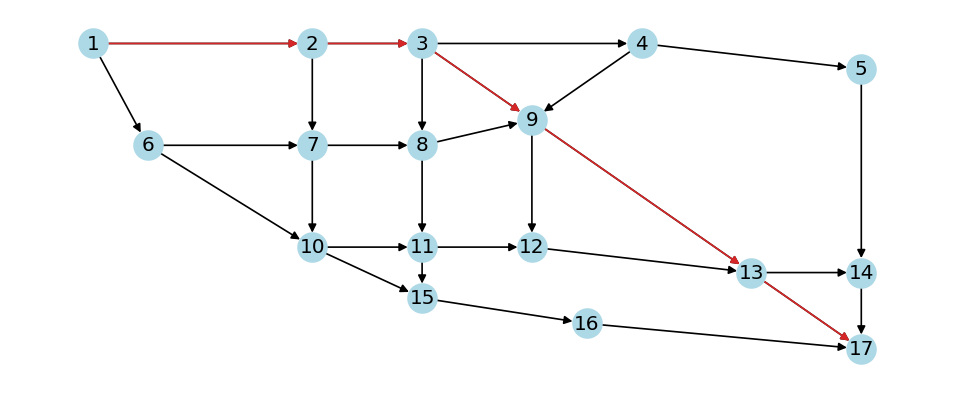

In [91]:
fig, ax = plt.subplots(figsize = (10,4), dpi=120)
nx.draw(G, pos, with_labels = True, node_color = 'lightblue')
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=[(1, 2), (2, 3), (3, 9), (9, 13), (13, 17)],
    edge_color="tab:red",
)

plt.savefig('fig/graph_3_shortest_path')



### b) Find the maximum node between 1 & 17

#### Find max flow

In [92]:
max_flow, flows = nx.maximum_flow(G,1,17)

#### Figure

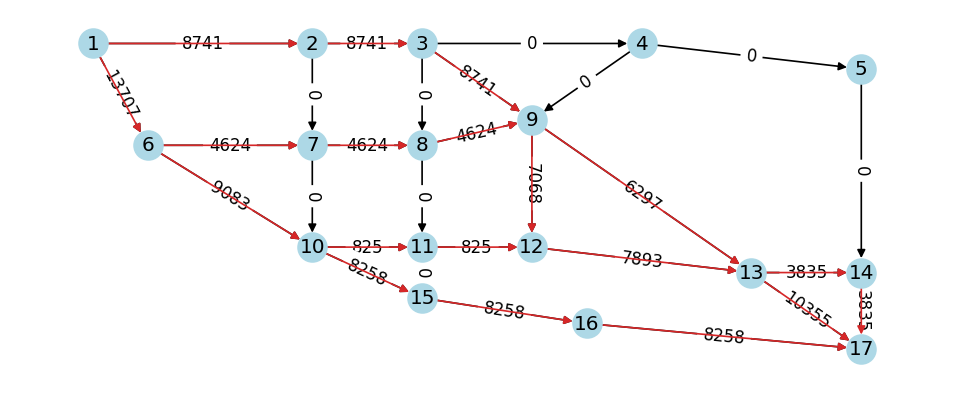

In [93]:
fig, ax = plt.subplots(figsize = (10,4), dpi=120)

edge_labels = {}
edge_list = []

for key in flows.keys():
    start = key
    for subkey in flows[key]:
        end = subkey
        edge_labels[(start, end)] = flows[start][end]
        if flows[start][end] != 0:
            edge_list.append((start, end))

nx.draw(G, pos, with_labels = True, node_color = 'lightblue')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw_networkx_edges(
    G,
    pos,
    edgelist=edge_list,
    edge_color="tab:red",
)

plt.savefig('fig/graph_3_max_flow.png')


### c) Compute external inflow

#### Calculate the exogenous flow given the internal flow

In [94]:
v = B @ f

#### All the positive components of v represent the exogenous inflow

In [95]:
print(v)

[ 16282   9094  19448   4957   -746   4768    413     -2  -5671   1169
     -5  -7131   -380  -7412  -7810  -3430 -23544]


#### Set up for next tast

In [96]:
v[1:] = 0
v[16] = -v[0]
print(v)

[ 16282      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0 -16282]


### d) Find the social optimal flow

In [97]:
model = grb.Model('gbpp')
model.params.NonConvex = 2
f = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'f'
)
z = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'z'
)
edges = range(n_edges)
nodes = range(n_nodes)
expr = -1*sum(
    l[e] * C[e] for e in edges
)
expr += grb.quicksum(
(l[e] * C[e]) * z[e] for e in edges
)

model.setObjective(expr,grb.GRB.MINIMIZE)
model.update()

model.addConstrs(
  grb.quicksum(B[n,e] * f[e] for e in edges) == v[n]  for n in nodes
)
model.addConstrs(
    (1 - f[e] / C[e]) * z[e] == 1 for e in edges
)
model.addConstrs(
    f[e] <= C[e] for e in edges
)


model.setParam(grb.GRB.Param.TimeLimit, 10)
model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 45 rows, 56 columns and 84 nonzeros
Model fingerprint: 0x67eb6236
Model has 28 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-05, 2e-04]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [4e+02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+03, 2e+04]
  QRHS range       [1e+00, 1e+00]
Presolve removed 29 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 30 rows and 2 columns
Presolve time: 0.00s
Presolved: 127 rows, 55 columns, 225 nonzeros
Presolved model has 28 bilinear constraint(s)
Variable types: 55 continuous, 0 integer (0 binary)

Root relaxation: objective 

 75473 25112     cutoff   46      23835.4844 22817.9936  4.27%   4.5    5s
 142320 44040 23611.4294   42   20 23835.4844 22980.2789  3.59%   4.5   10s

Cutting planes:
  RLT: 76

Explored 142812 nodes (647863 simplex iterations) in 10.01 seconds (2.16 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 23835.5 

Time limit reached
Best objective 2.383548441321e+04, best bound 2.298070099337e+04, gap 3.5862%
computational time: 10.02220869064331 s


In [98]:
social_optimal_f = [] 
for e in edges:
    social_optimal_f.append(model.getVarByName(f'f[{e}]').X)

print(social_optimal_f)

[6454.118955157337, 5919.416013643907, 2995.291348400669, 2995.2913483643415, 9827.881044842663, 4497.067855087033, 2897.423897607405, 2435.972810332471, 3047.329627141479, 534.70294151343, 1.9364050324388048e-07, 2924.1246650495978, 3.632728957753562e-08, 2995.2913483643415, 5330.8131897556295, 2730.8594256035017, 4734.300663145186, 2134.3468989930584, 461.45108746857426, 2312.7678482769174, 3192.310513025859, 5505.078361302776, 2310.527956744172, 4.6216744818117195e-08, 6241.880031700083, 5305.819305108514, 4734.300663191403, 4734.300663191403]


### e) Find user optimal flow (*Wardrop equilibrium* $f^{(0)}$)

In [99]:

model = grb.Model('gbpp')

f = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'f'
)
z = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'z'
)
w = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = -grb.GRB.INFINITY,
    name = 'w'
)

edges = range(n_edges)
nodes = range(n_nodes)


expr = grb.quicksum(
-(l[e] * C[e]) * w[e] for e in edges
)

model.setObjective(expr,grb.GRB.MINIMIZE)
model.update()

model.addConstrs(
  grb.quicksum(B[n,e] * f[e] for e in edges) == v[n]  for n in nodes
)
model.addConstrs(
    z[e] * C[e] == C[e] - f[e] for e in edges
)

for e in edges:
    model.addGenConstrLog(z[e], w[e])

model.addConstrs(
    f[e] <= C[e] for e in edges
)


model.setParam(grb.GRB.Param.TimeLimit, 300)
model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Set parameter TimeLimit to value 300
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



Optimize a model with 73 rows, 84 columns and 140 nonzeros
Model fingerprint: 0xa9266fe4
Model has 28 general constraints
Variable types: 84 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [4e+02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+03, 2e+04]
Presolve added 19 rows and 3810 columns
Presolve time: 0.01s
Presolved: 92 rows, 3894 columns, 11586 nonzeros
Presolved model has 28 SOS constraint(s)
Variable types: 3894 continuous, 0 integer (0 binary)

Root relaxation: objective 1.493177e+04, 682 iterations, 0.02 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    14931.766808 14931.7668  0.00%     -    0s

Explored 1 nodes (682 simplex iterations) in 0.06 seconds (0.02 work units)
Thread count was 8 (of 8 available processors)

Solution count 1: 1

In [100]:
user_optimal_f = [] 
for e in edges:
    user_optimal_f.append(model.getVarByName(f'f[{e}]').X)

print(user_optimal_f)

[6542.001738554947, 6542.001738554947, 2230.9567388115283, 2230.9567388115283, 9739.998261445053, 4505.480240354848, 2704.9296633455824, 2212.7276024807775, 3337.1329020133635, 0.0, 198.41363893378772, 4112.631360809632, 0.0, 2230.9567388115283, 5234.518021090204, 2260.505075794362, 4774.563522305109, 1800.550577009266, 690.6156997985918, 2988.2260612770456, 2951.1207755929536, 5939.34683687, 2486.266989923484, 0.0, 6790.21274895988, 4717.223728735013, 4774.563522305109, 4774.563522305109]


### f) Find user optimal flow with toll (*Wardrop equilibrium* $f^{(\omega)}$)

In [101]:
toll = np.zeros(n_edges)
for e in edges:
  toll[e] = (social_optimal_f[e] * l[e] * C[e]) / (C[e]-social_optimal_f[e])**2


In [102]:
model = grb.Model('gbpp')
f = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'f'
)
z = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'z'
)
w = model.addVars(
    n_edges,
    lb = -grb.GRB.INFINITY,
    vtype = grb.GRB.CONTINUOUS,
    name = 'w'
)

edges = range(n_edges)
nodes = range(n_nodes)
expr = 0
expr += grb.quicksum(
-1 * C[e]*l[e]* w[e] + f[e] * toll[e] for e in edges
)

model.setObjective(expr,grb.GRB.MINIMIZE)
model.update()

model.addConstrs(
  grb.quicksum(B[n,e] * f[e] for e in edges) == v[n]  for n in nodes
)
model.addConstrs(
    f[e] <= C[e] for e in edges
)
model.addConstrs(
    z[e] == 1 - f[e] / C[e] for e in edges
)
model.addConstrs(
    f[e] >= 0 for e in edges
)
for e in edges:
  model.addGenConstrLog(z[e],w[e])

model.setParam(grb.GRB.Param.TimeLimit, 10)
model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 101 rows, 84 columns and 168 nonzeros
Model fingerprint: 0xe393c2c6
Model has 28 general constraints
Variable types: 84 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-05, 1e+00]
  Objective range  [3e-13, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Presolve added 0 rows and 3810 columns
Presolve removed 9 rows and 0 columns
Presolve time: 0.01s
Presolved: 92 rows, 3894 columns, 11586 nonzeros
Presolved model has 28 SOS constraint(s)
Variable types: 3894 continuous, 0 integer (0 binary)

Root relaxation: objective 5.275600e+04, 631 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

In [103]:
wardrop_toll_f = np.zeros(n_edges)

for e in edges:
  wardrop_toll_f[e] = f[e].X

print(wardrop_toll_f)

[6477.03389421 5917.52721431 2996.20161908 2996.20161908 9804.96610579
 4471.81213012 2901.47426068 2433.78069143 3045.31501918  559.5066799
    0.         2921.32559524    0.         2996.20161908 5333.15397567
 2714.66237529 4748.33614972 2129.84454934  467.69356924 2309.79126749
 3182.35594453 5492.14721203 2295.67828994    0.         6241.78394127
 5291.87990902 4748.33614972 4748.33614972]


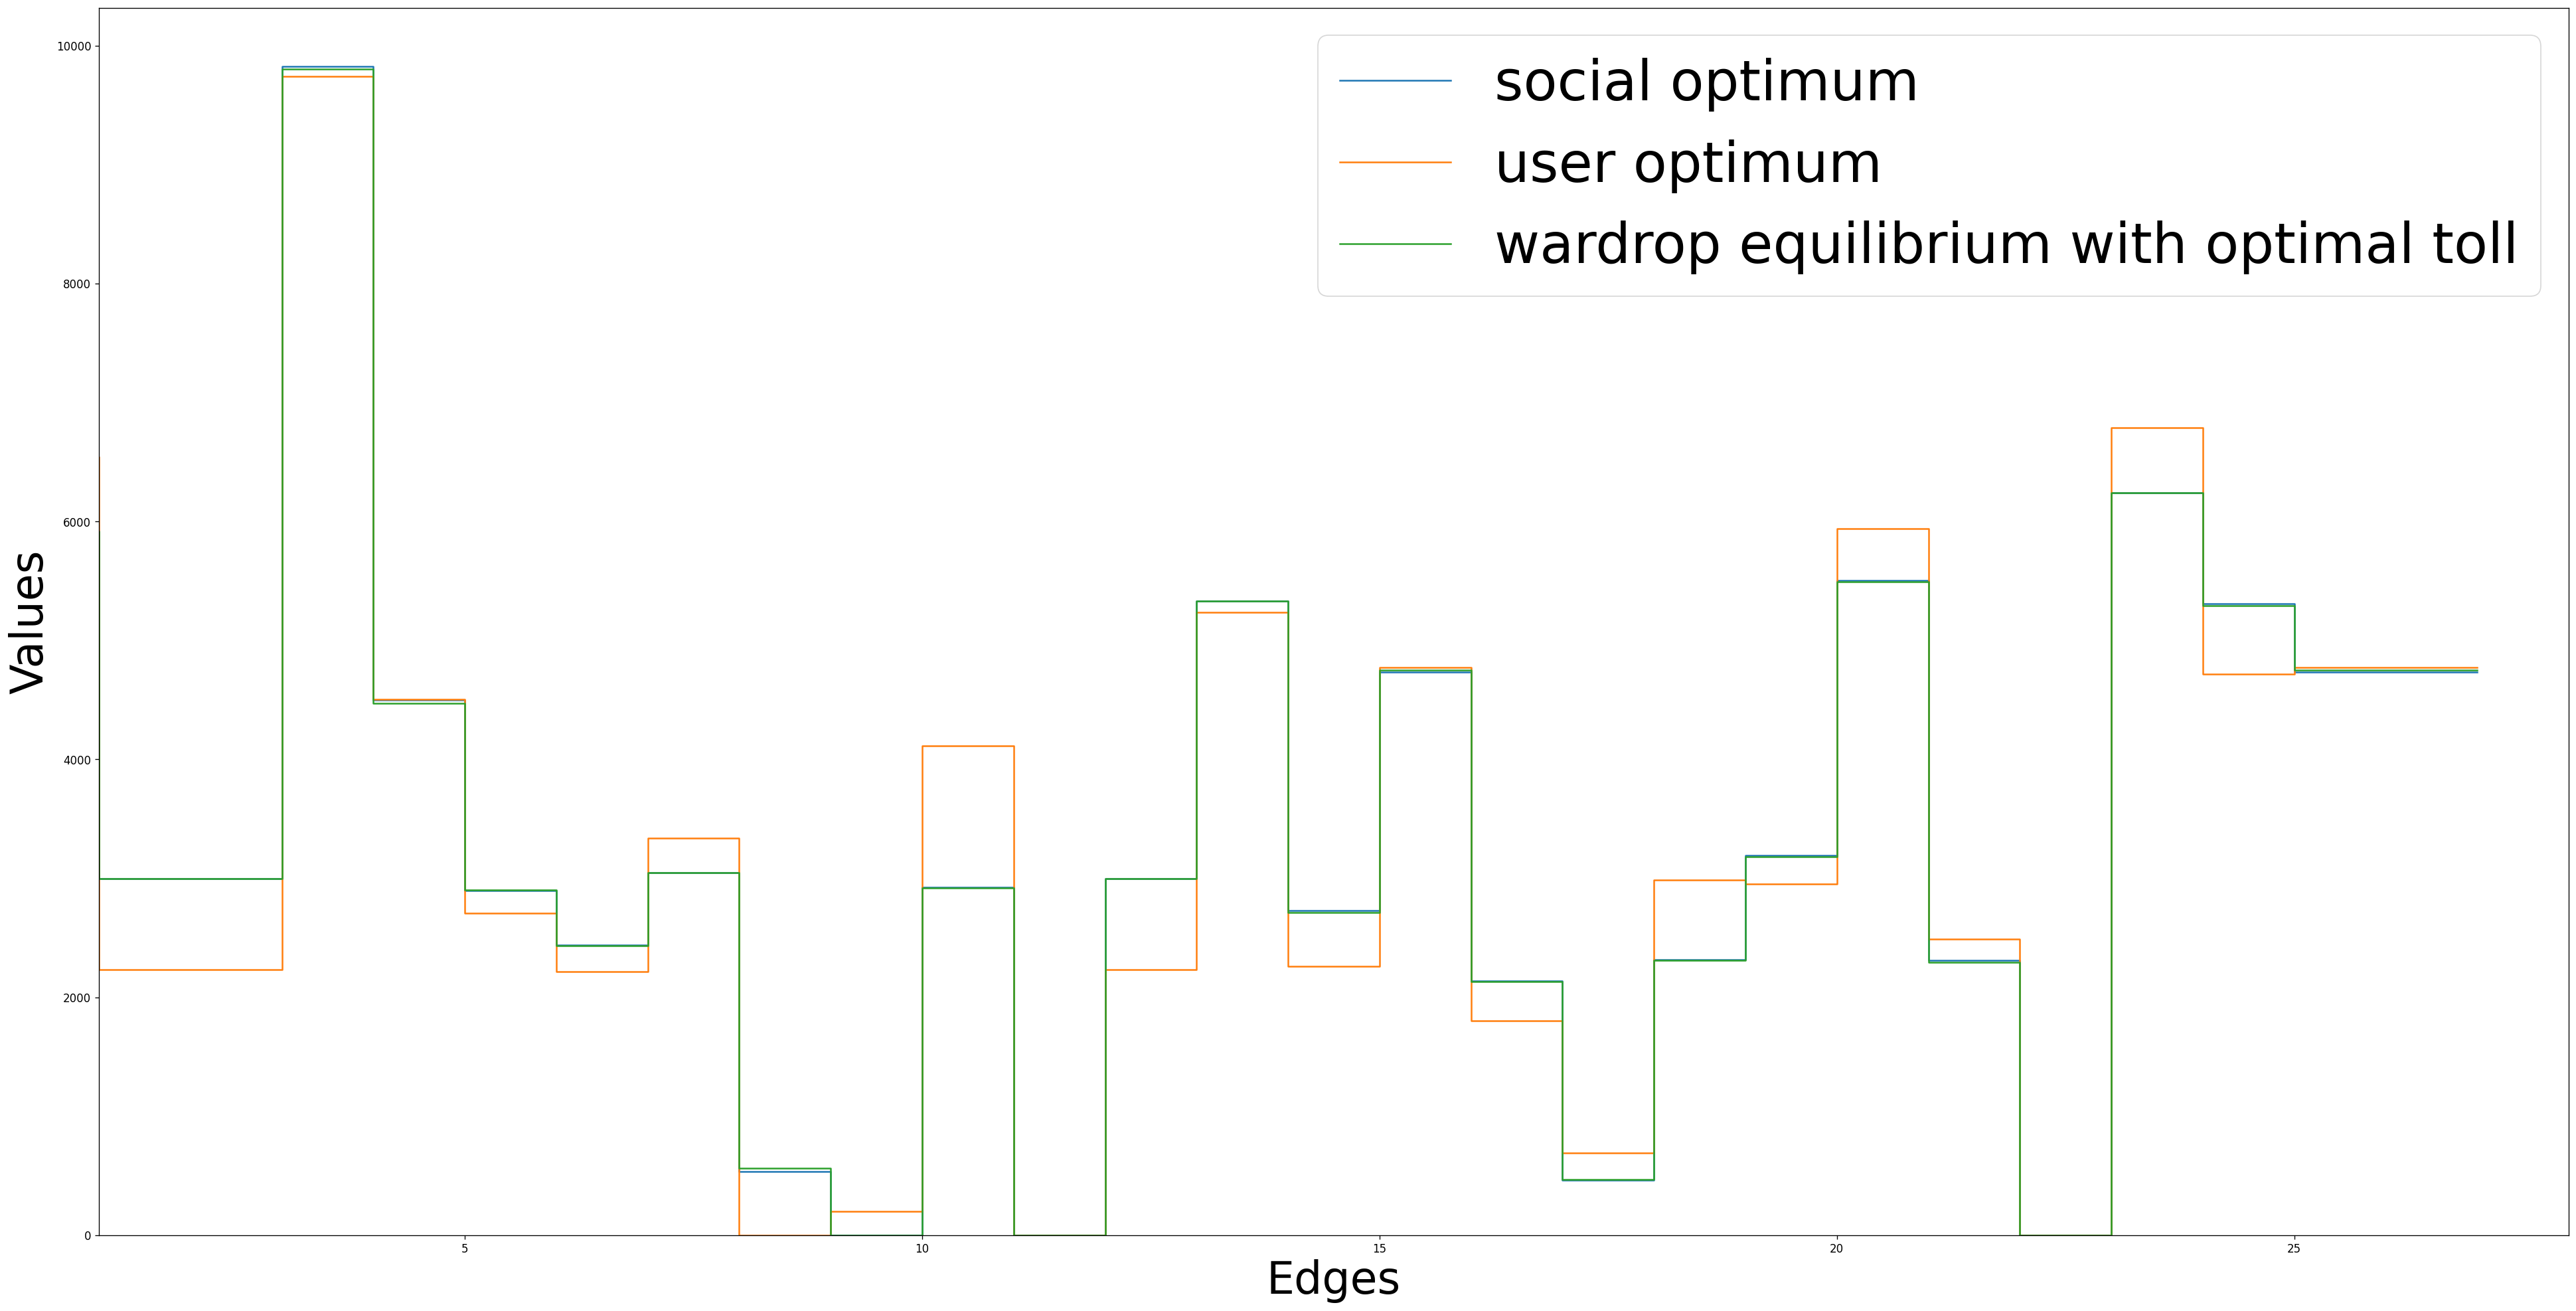

In [111]:
fig ,ax = plt.subplots(figsize=(40,20),dpi=120)

ax.step(range(len(social_optimal_f)), social_optimal_f, label = 'social optimum')
ax.step(range(len(user_optimal_f)), user_optimal_f, label = 'user optimum')
ax.step(range(len(wardrop_toll_f)), wardrop_toll_f, label = 'wardrop equilibrium with optimal toll')

ax.legend(fontsize = 50)

ax.set_xlabel("Edges", fontsize = 40)
ax.set_xlim(left = 1.0, right = 28)

ax.set_ylabel("Values", fontsize = 40)
ax.set_ylim(bottom = 0.0)

plt.savefig('fig/graph_3_f')
plt.show()



### g) Find the social optimal flow user optimal flow with toll (*Wardrop equilibrium* $f^{(\omega)}$) of a different delay function

In [105]:
model = grb.Model('gbpp')
model.params.NonConvex = 2

f = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'f'
)
z = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'z'
)


edges = range(n_edges)
nodes = range(n_nodes)

expr = -1 * sum(
    C[e] * l[e] for e in edges
)


expr += grb.quicksum(
(l[e] * C[e] * z[e]) - l[e] * f[e] for e in edges
)

model.setObjective(expr,grb.GRB.MINIMIZE)
model.update()

model.addConstrs(
  grb.quicksum(B[n,e] * f[e] for e in edges) == v[n]  for n in nodes
)
model.addConstrs(
    f[e] <= C[e] for e in edges
)
model.addConstrs(
    (1 - f[e] / C[e]) * z[e] == 1 for e in edges
)


model.setParam(grb.GRB.Param.TimeLimit, 10)
model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Set parameter NonConvex to value 2
Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 45 rows, 56 columns and 84 nonzeros
Model fingerprint: 0x3d7f47e5
Model has 28 quadratic constraints
Coefficient statistics:


  Matrix range     [1e+00, 1e+00]
  QMatrix range    [7e-05, 2e-04]
  QLMatrix range   [1e+00, 1e+00]
  Objective range  [3e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+03, 2e+04]
  QRHS range       [1e+00, 1e+00]
Presolve removed 29 rows and 0 columns

Continuous model is non-convex -- solving as a MIP

Presolve removed 30 rows and 2 columns
Presolve time: 0.00s
Presolved: 127 rows, 55 columns, 225 nonzeros
Presolved model has 28 bilinear constraint(s)
Variable types: 55 continuous, 0 integer (0 binary)

Root relaxation: objective 2.266859e+03, 35 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 2266.85876    0   16          - 2266.85876      -     -    0s
H    0     0                    13334.304830 2266.85876  83.0%     -    0s
     0     0 3722.33067    0   25 13334.3048 3722.33067  72.1%     -    0s
 

In [106]:
social_optimal_f_2 = np.zeros(n_edges)
for e in edges:
  social_optimal_f_2[e] = f[e].X

print(social_optimal_f_2)

[6.46809016e+03 5.61798604e+03 3.29755390e+03 3.29755390e+03
 9.81390984e+03 4.50158656e+03 3.00281048e+03 2.56413207e+03
 2.91783002e+03 8.50104117e+02 4.31396323e-07 2.32043214e+03
 2.67671824e-07 3.29755390e+03 5.31232328e+03 2.93147761e+03
 4.72972586e+03 2.34888019e+03 4.38678408e+02 1.96673419e+03
 3.37015602e+03 5.33689021e+03 2.14297555e+03 9.71785994e-08
 6.11174468e+03 5.44052946e+03 4.72972586e+03 4.72972586e+03]


In [107]:
toll = np.zeros(n_edges)
for e in edges:
  toll[e] = (social_optimal_f_2[e] * l[e] * C[e]) / (C[e]-social_optimal_f_2[e])**2


In [108]:
model = grb.Model('gbpp')
f = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'f'
)
z = model.addVars(
    n_edges,
    vtype = grb.GRB.CONTINUOUS,
    lb = 0,
    name = 'z'
)
w = model.addVars(
    n_edges,
    lb = -grb.GRB.INFINITY,
    vtype = grb.GRB.CONTINUOUS,
    name = 'w'
)

edges = range(n_edges)
nodes = range(n_nodes)
expr = 0
expr += grb.quicksum(
-1 * C[e]*l[e]* w[e] - l[e] * f[e] + f[e] * toll[e] for e in edges
)

model.setObjective(expr,grb.GRB.MINIMIZE)
model.update()

model.addConstrs(
  grb.quicksum(B[n,e] * f[e] for e in edges) == v[n]  for n in nodes
)
model.addConstrs(
    f[e] <= C[e] for e in edges
)
model.addConstrs(
    z[e] == 1 - f[e] / C[e] for e in edges
)
model.addConstrs(
    f[e] >= 0 for e in edges
)
for e in edges:
  model.addGenConstrLog(z[e],w[e])

model.setParam(grb.GRB.Param.TimeLimit, 10)
model.setParam('OutputFlag', 1)

start = time.time()
model.optimize()
end = time.time()
comp_time = end - start
print(f"computational time: {comp_time} s")

Set parameter TimeLimit to value 10
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i5-8250U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 101 rows, 84 columns and 168 nonzeros
Model fingerprint: 0x3b3b3e55
Model has 28 general constraints
Variable types: 84 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-05, 1e+00]
  Objective range  [7e-04, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Presolve added 0 rows and 3810 columns
Presolve removed 9 rows and 0 columns
Presolve time: 0.01s
Presolved: 92 rows, 3894 columns, 11586 nonzeros
Presolved model has 28 SOS constraint(s)
Variable types: 3894 continuous, 0 integer (0 binary)

Root relaxation: objective 4.202361e+04, 717 iterations, 0.01 seconds (0.01 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Exp

In [109]:
wardrop_toll_f_2 = np.zeros(n_edges)
for e in edges:
  wardrop_toll_f_2[e] = f[e].X

print(wardrop_toll_f_2)

[6477.03389421 5612.08330873 3292.16188821 3292.16188821 9804.96610579
 4510.31555379 2999.74655934 2566.41254481 2920.25021224  864.95058548
    0.         2319.92142052    0.         3292.16188821 5294.650552
 2948.22511461 4721.94501732 2375.51957993  433.33401453 1966.08375308
 3381.55912914 5347.64288223 2163.21635513    0.         6104.67673934
 5455.37824333 4721.94501732 4721.94501732]


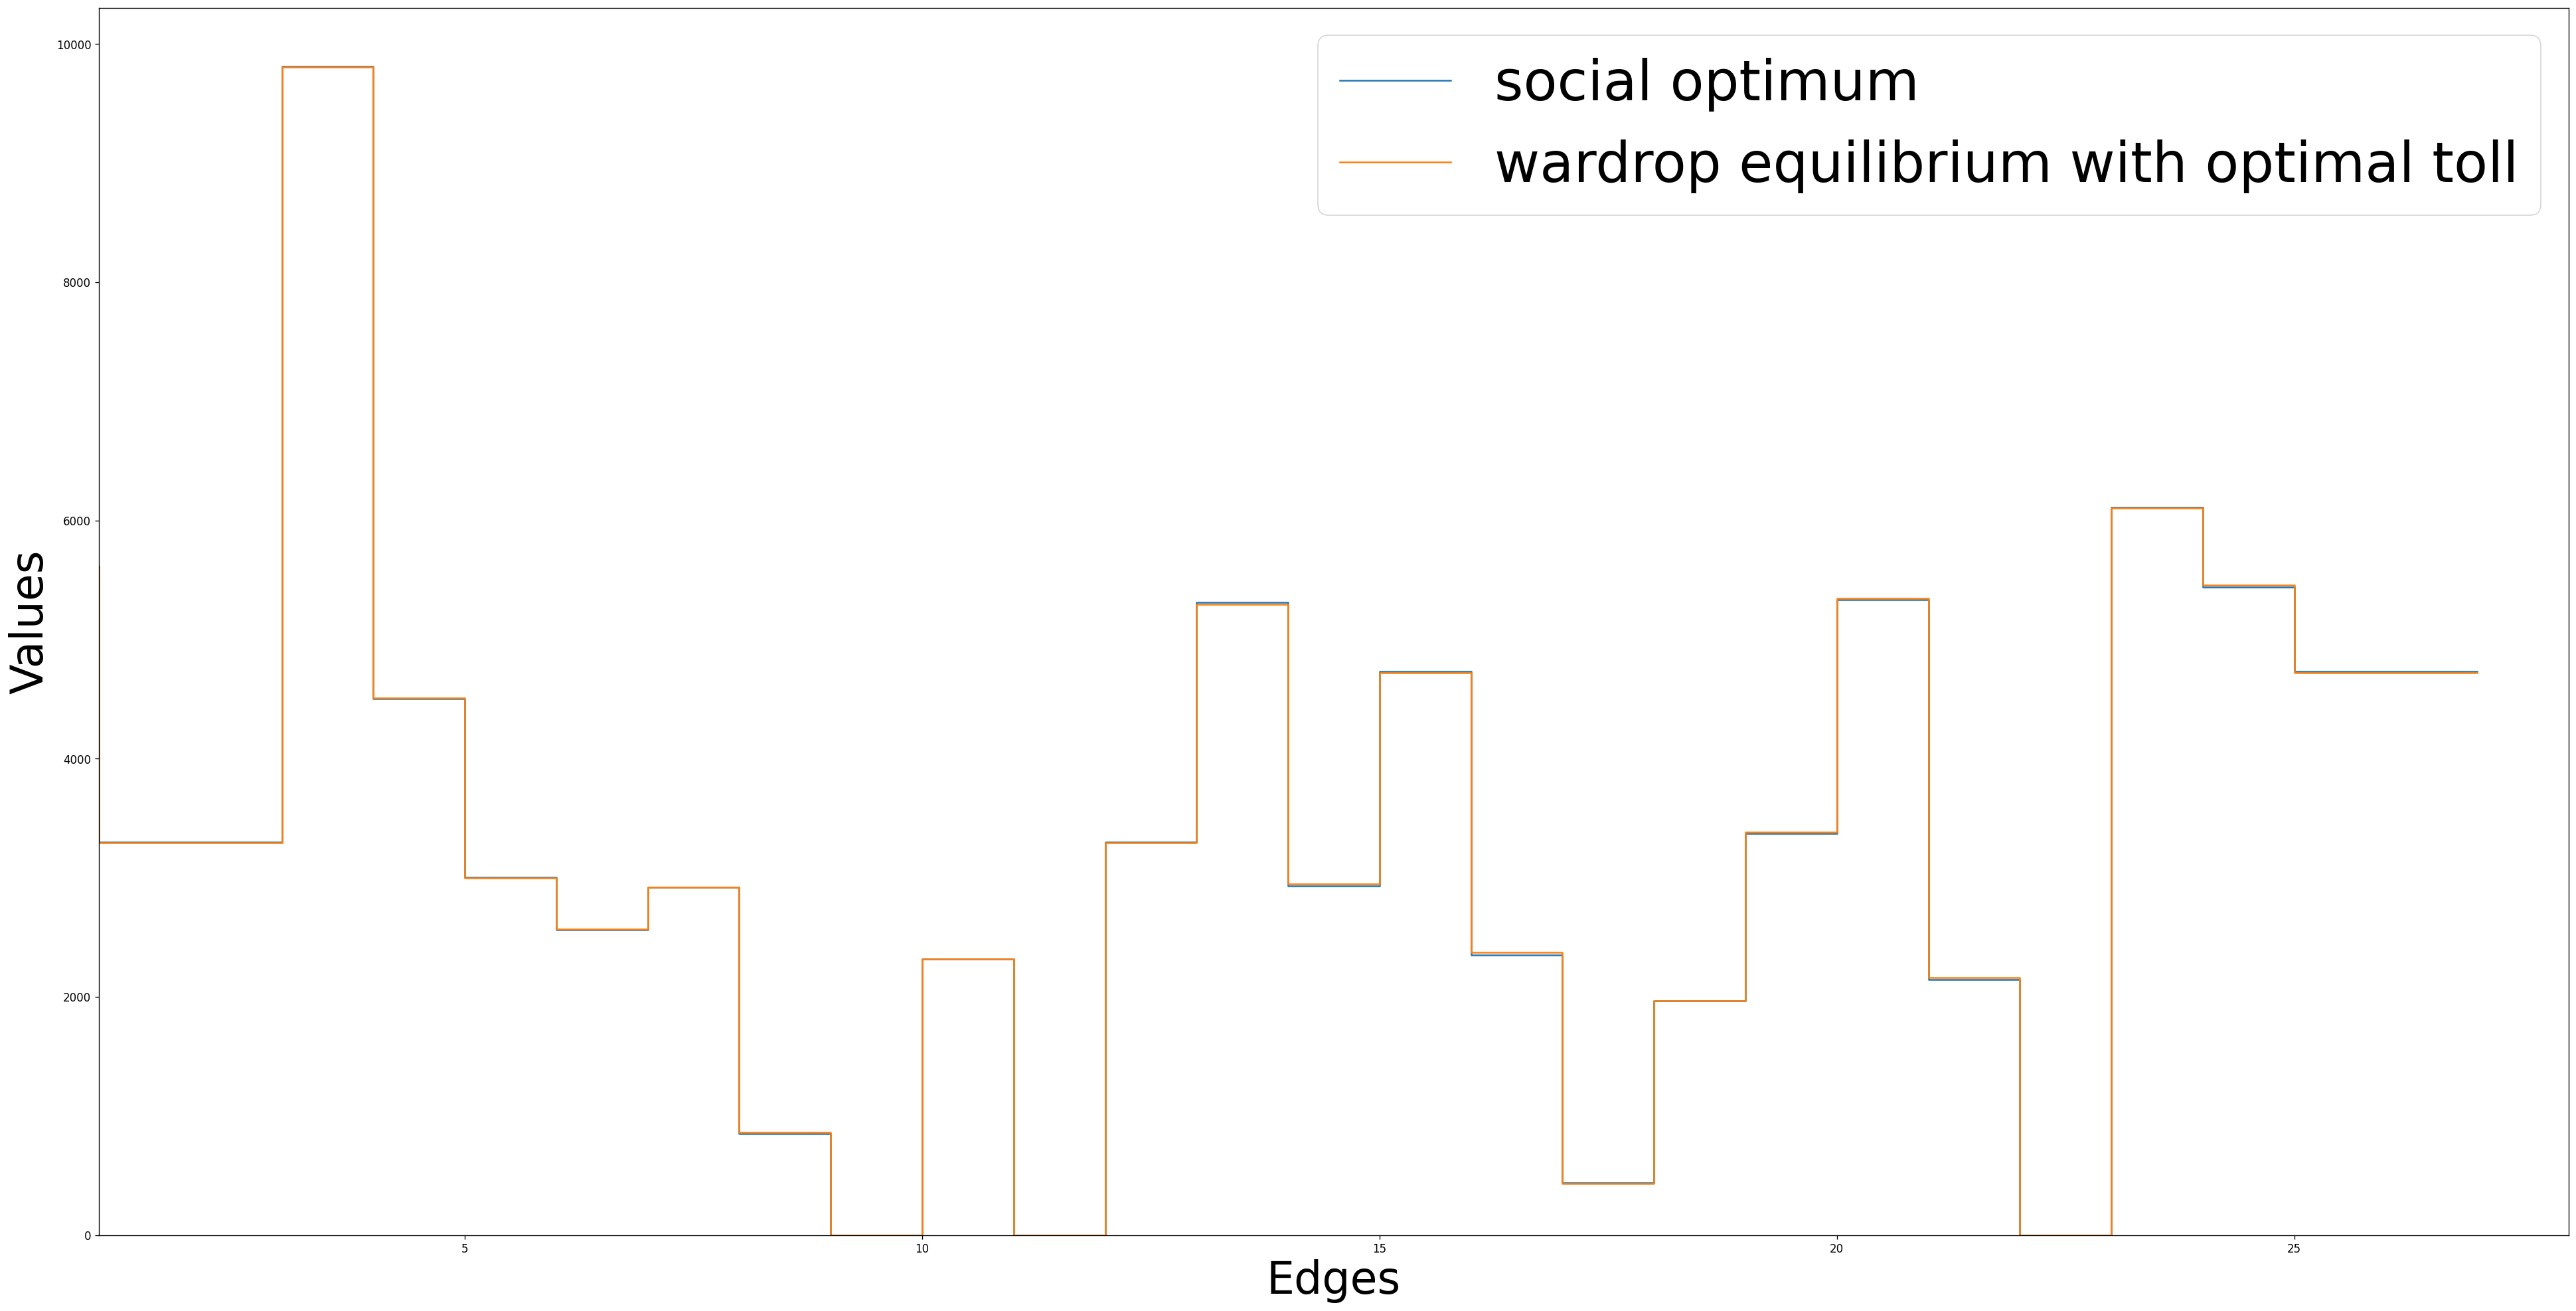

In [112]:
fig,ax = plt.subplots(figsize=(40,20),dpi=120)

ax.step(range(len(social_optimal_f_2)), social_optimal_f_2, label = 'social optimum')
ax.step(range(len(wardrop_toll_f_2)), wardrop_toll_f_2, label = 'wardrop equilibrium with optimal toll')

ax.legend(fontsize = 50)

ax.set_xlabel("Edges", fontsize = 40)
ax.set_xlim(left = 1.0, right = 28)

ax.set_ylabel("Values", fontsize = 40)
ax.set_ylim(bottom = 0.0)

plt.savefig('fig/graph_3_g')

plt.show()

